Librerias

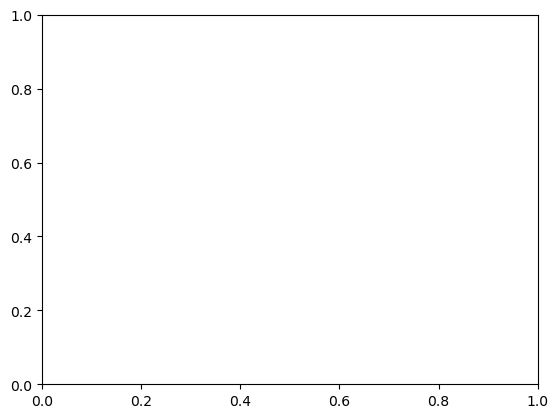

In [2]:
import scipy.io
import matplotlib.pyplot as plt
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
import math
import datetime
import csv
from sklearn.utils import shuffle
from scipy.signal import butter, filtfilt, decimate, freqz
import funciones as mifu

Aplicamos un filtro pasabanda:

In [ ]:
sujeto = 1
prediccion = 'modalidad'

datos = mifu.extraer(sujeto)
datos_ordenados = mifu.ordenar(datos)

corte_bajo = 9
corte_alto = 28
orden = 5
fs = 1024
datos_filtrados = mifu.filtrar_butterworth(datos_ordenados, 'band', corte_bajo, corte_alto, fs, orden)

# Hacemos un downsampling a 128 Hz
fs_original = 1024
fs_nueva = 128
factor = fs_original // fs_nueva
datos_downsampleados = [np.empty((datos_ordenados[0].shape[0], fs_nueva*4*6)), datos_filtrados[1]]
for i in range(6):
    datos_downsampleados[0][:,fs_nueva*4*i:fs_nueva*4*(i+1)] = decimate(datos_filtrados[0][:,4096*i:4096*(i+1)], factor, axis = 1, zero_phase = True)

datos_normalizados = mifu.normalizar(datos_downsampleados)
datos_divididos = mifu.dividir_datos(datos_normalizados, 0.25, prediccion, random.randint(0, 999999))

Probemos ver el espacio de frecuencias y que pasa con el filtrado y downsampling

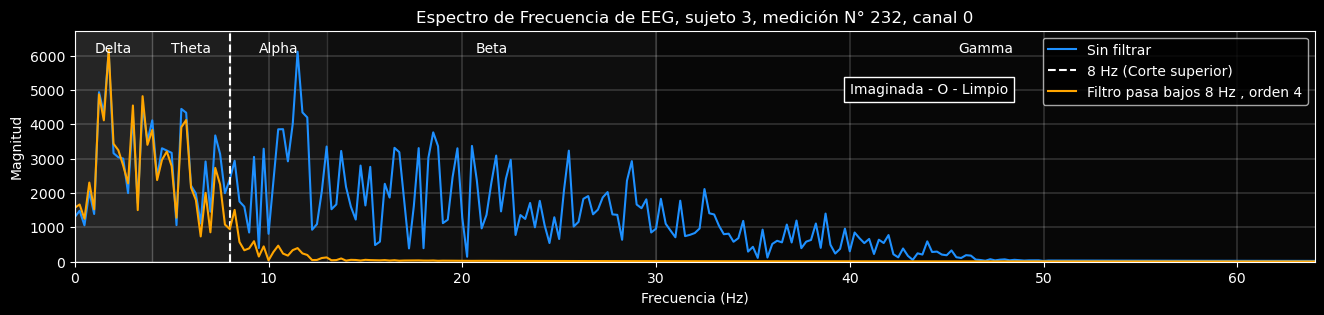

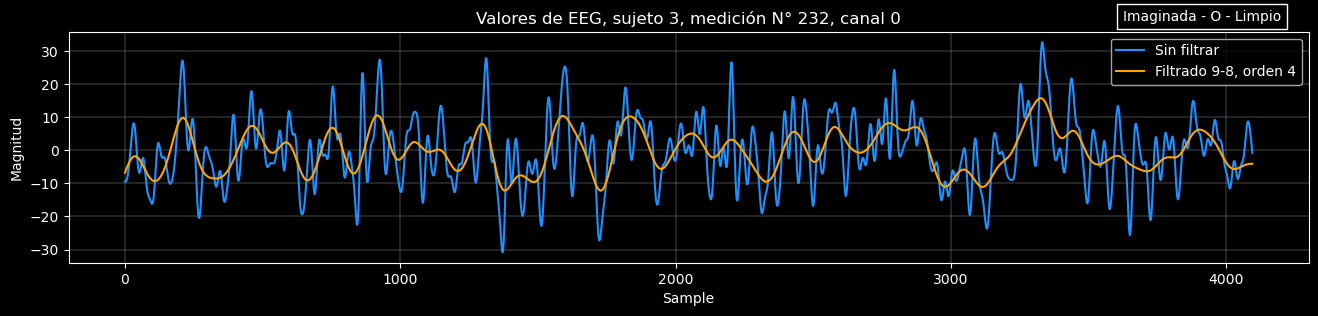

In [4]:
sujeto = random.randint(1, 15)
datos = mifu.extraer(sujeto)
datos_ordenados = mifu.ordenar(datos)
fs = 1024
dato = random.randint(0, datos_ordenados[0].shape[0] - 1)
canal = random.randint(0, 5)

# Veamos el espacio de frecuencias de estos datos, y los contrastamos con el de la señal tras ser filtrada, usamos solo los valores positivos
magnitudes_fft_sin_filtrar = np.abs(np.fft.fft(datos_ordenados[0][dato][canal*4096:(canal + 1)*4096]))
frecuencias_sin_filtrar = np.fft.fftfreq(len(datos_ordenados[0][dato][canal*4096:(canal + 1)*4096]), d = 1/fs)
magnitudes_fft_sin_filtrar = magnitudes_fft_sin_filtrar[:len(frecuencias_sin_filtrar)//2]
frecuencias_sin_filtrar = frecuencias_sin_filtrar[:len(frecuencias_sin_filtrar)//2]

# Filtro
corte_bajo = 9
corte_alto = 8
orden = 4
tipo = 'low'
datos_filtrados = mifu.filtrar_butterworth(datos_ordenados, tipo, corte_bajo, corte_alto, fs, orden)
magnitudes_fft_filtrado = np.abs(np.fft.fft(datos_filtrados[0][dato][canal*4096:(canal + 1)*4096]))
frecuencias_filtrado = np.fft.fftfreq(len(datos_filtrados[0][dato][canal*4096:(canal + 1)*4096]), d = 1/fs)
magnitudes_fft_filtrado = magnitudes_fft_filtrado[:len(frecuencias_sin_filtrar)//2]
frecuencias_filtrado = frecuencias_filtrado[:len(frecuencias_sin_filtrar)//2]

indice = (datos_filtrados[1][dato] - 1).astype(int)
ref_etiq = [['Imaginada', 'Pronunciada'][indice[0]], ['A', 'E', 'I', 'O', 'U', 'Arriba', 'Abajo', 'Adelante', 'Atras', 'Derecha', 'Izquierda'][indice[1]], ['Limpio', 'Parpadeo'][indice[2]]]
ref_etiq = str(ref_etiq[0]) + ' - ' + str(ref_etiq[1]) + ' - ' + str(ref_etiq[2])

# Grafico frecuencias
plt.figure(figsize=(16, 3))
plt.style.use('dark_background')
ondas_cerebrales = [
    {"nombre": "Delta", "inicio": 0, "fin": 4, 'tr': 0.15},
    {"nombre": "Theta", "inicio": 4, "fin": 8, 'tr': 0.12},
    {"nombre": "Alpha", "inicio": 8, "fin": 13, 'tr': 0.09},
    {"nombre": "Beta", "inicio": 13, "fin": 30, 'tr': 0.06},
    {"nombre": "Gamma", "inicio": 30, "fin": 64, 'tr': 0.03}
]
for onda in ondas_cerebrales:
    plt.axvspan(onda["inicio"], onda["fin"], color = 'white', alpha = onda['tr'])
    x_pos = (onda["inicio"] + onda["fin"]) / 2
    y_pos = 1.05*max(magnitudes_fft_sin_filtrar)
    plt.text(x_pos, y_pos, onda["nombre"], fontsize=10, ha='center', va='top', color='white')


plt.plot(frecuencias_sin_filtrar, magnitudes_fft_sin_filtrar, label = 'Sin filtrar', color = 'dodgerblue')
plt.xlim(0, 64)
plt.title("Espectro de Frecuencia de EEG, sujeto " + str(sujeto) + ', medición N° ' + str(dato + 1) + ', canal ' + str(canal))
plt.xlabel("Frecuencia (Hz)")
plt.ylabel("Magnitud")
plt.ylim(0, max(magnitudes_fft_sin_filtrar)*1.1)
if tipo == 'band':
    plt.axvline(corte_bajo, color='white', linestyle='--', label=f'{corte_bajo} Hz (Corte inferior)')
    plt.axvline(corte_alto, color='white', linestyle='--', label=f'{corte_alto} Hz (Corte superior)')
    plt.plot(frecuencias_filtrado, magnitudes_fft_filtrado, label = ('Filtro pasabanda ' + str(corte_bajo) + '-' + str(corte_alto) + ' Hz , orden ' + str(orden)), color = 'orange')
elif tipo == 'low':
    plt.axvline(corte_alto, color='white', linestyle='--', label=f'{corte_alto} Hz (Corte superior)')
    plt.plot(frecuencias_filtrado, magnitudes_fft_filtrado, label = ('Filtro pasa bajos ' + str(corte_alto) + ' Hz , orden ' + str(orden)), color = 'orange')
elif tipo == 'high':
    plt.axvline(corte_bajo, color='white', linestyle='--', label=f'{corte_bajo} Hz (Corte inferior)')
    plt.plot(frecuencias_filtrado, magnitudes_fft_filtrado, label = ('Filtro pasa altos ' + str(corte_bajo) + ' Hz , orden ' + str(orden)), color = 'orange')
plt.text(40, max(magnitudes_fft_sin_filtrar)*0.8, ref_etiq, fontsize=10, bbox = dict(facecolor='black', alpha = 1.0))
plt.grid(linewidth = 0.2)
plt.legend()
plt.show()

# Grafico valores
plt.figure(figsize=(16, 3))
plt.style.use('dark_background')
plt.plot(datos_ordenados[0][dato][canal*4096:(canal + 1)*4096], label = 'Sin filtrar', color = 'dodgerblue')
plt.plot(datos_filtrados[0][dato][canal*4096:(canal + 1)*4096], label = ('Filtrado ' + str(corte_bajo) + '-' + str(corte_alto) + ', orden ' + str(orden)), color = 'orange')
plt.title("Valores de EEG, sujeto " + str(sujeto) + ', medición N° ' + str(dato + 1) + ', canal ' + str(canal))
plt.xlabel("Sample")
plt.ylabel("Magnitud")
plt.text(4200, 1.3*max(np.max(datos_ordenados[0][dato][canal*4096:(canal + 1)*4096]), np.max(datos_filtrados[0][dato][canal*4096:(canal + 1)*4096])), ref_etiq, fontsize=10, ha='right', va='top', bbox = dict(facecolor='black', alpha = 1.0))
plt.grid(linewidth = 0.2)
plt.legend()
plt.show()

In [8]:
print(datos_ordenados[1].shape)
datos_ordenados[1]

(641, 3)


array([[ 1., 11.,  1.],
       [ 1.,  6.,  1.],
       [ 1., 10.,  1.],
       ...,
       [ 2.,  2.,  1.],
       [ 2.,  1.,  1.],
       [ 2.,  5.,  1.]])

Voy a probar hacer prediccion del estimulo usando paralelamente la señal normal, y la filtrada

    Nota: No hay downsampling en esta prueba

In [ ]:
sin_filtro = []
filtrado = []

for i in range(1000):
    sujeto = random.randint(1, 15)
    datos = mifu.extraer(sujeto)
    datos_ordenados = mifu.ordenar(datos)

    fraccion_entrenamiento = 0.25
    prediccion = 'estimulo'
    aleatorizador = random.randint(0, 999999)

    datos_normalizados_sin_filtrar = mifu.normalizar(datos_ordenados)
    datos_divididos_sin_filtrar = mifu.dividir_datos(datos_normalizados_sin_filtrar, fraccion_entrenamiento, prediccion, aleatorizador)

    fs = 1024
    corte_bajo = 9
    corte_alto = 28
    orden = 4
    tipo = 'band'
    datos_filtrados = mifu.filtrar_butterworth(datos_ordenados, tipo, corte_bajo, corte_alto, fs, orden)
    datos_normalizados_filtrados = mifu.normalizar(datos_filtrados)
    datos_divididos_filtrados = mifu.dividir_datos(datos_normalizados_filtrados, fraccion_entrenamiento, prediccion, aleatorizador)

    neuronas_entrada = datos_divididos_filtrados[0][0].shape[1]
    ocultas = [256, 256]
    neuronas_salida = 11
    epocas = 1000
    plotear = 0
    tol = 1e-5
    ls = 0.0001

    datos_divididos_sin_filtrar[0][0], datos_divididos_sin_filtrar[0][1], datos_divididos_filtrados[0][0], datos_divididos_filtrados[0][1] = shuffle(datos_divididos_sin_filtrar[0][0], datos_divididos_sin_filtrar[0][1], datos_divididos_filtrados[0][0], datos_divididos_filtrados[0][1], random_state = aleatorizador)

    modelo_sin_filtrar = mifu.MLP(neuronas_entrada, ocultas, neuronas_salida)
    modelo_filtrados = mifu.MLP(neuronas_entrada, ocultas, neuronas_salida)

    mifu.MLP.entrenar(modelo_sin_filtrar, epocas, datos_divididos_sin_filtrar[0][0], datos_divididos_sin_filtrar[0][1], plotear, tol, ls)
    mifu.MLP.entrenar(modelo_filtrados, epocas, datos_divididos_filtrados[0][0], datos_divididos_filtrados[0][1], plotear, tol, ls)

    precision_sin_filtrar, predicciones_sin_filtrar = mifu.MLP.evaluar(modelo_sin_filtrar, datos_divididos_sin_filtrar[1][0], datos_divididos_sin_filtrar[1][1])
    precision_filtrados, predicciones_filtrados = mifu.MLP.evaluar(modelo_filtrados, datos_divididos_filtrados[1][0], datos_divididos_filtrados[1][1])

    sin_filtro.append(precision_sin_filtrar)
    filtrado.append(precision_filtrados)

# print(np.bincount(predicciones), np.bincount(datos_divididos[1][1]))
# print(predicciones)
# print(datos_divididos[1][1])

In [21]:
print(np.mean(np.array(sin_filtro)), np.mean(np.array(filtrado)))
print(np.std(np.array(sin_filtro), ddof = 1)/math.sqrt(len(sin_filtro)), np.std(np.array(filtrado), ddof = 1)/math.sqrt(len(filtrado)))

# with open('sin-con_filtro.csv', mode = 'w', newline = '', encoding = 'utf-8') as archivo:
#     escritor = csv.writer(archivo)
#     escritor.writerow(['Sin filtrar', 'Filtrado'])
#     for v1, v2 in zip(sin_filtro, filtrado):
#         escritor.writerow([v1, v2])

print(np.max(np.array(sin_filtro)), np.max(np.array(filtrado)))
print(np.min(np.array(sin_filtro)), np.min(np.array(filtrado)))

0.5823404233648057 0.6290472413270317
0.04613893391835283 0.046070268025295555
0.7572992700729927 0.7445255474452555
0.514161220043573 0.5037174721189591


In [ ]:
plt.figure(figsize=(16, 3))
n = 1
for i in range(1):
    plt.plot(range(0,4096, 1), datos_ordenados[0][n][i*4096:(i+1)*4096]/100)
    plt.plot(range(0,4096, 4096//(fs_nueva*4)), datos_normalizados[0][n][i*fs_nueva*4:(i+1)*fs_nueva*4], label = str(datos_normalizados[1][n]))
plt.style.use('dark_background')
plt.legend()
plt.show()


b, a = mifu.filtrar_butterworth(tipo, corte_bajo, corte_alto, fs, orden)
w, h = freqz(b, a, worN=2000)  # 'w' en radianes/segundo, 'h' es la respuesta
frequencies = w * fs / (2 * np.pi)
magnitude_db = 20 * np.log10(abs(h))
plt.figure(figsize=(16, 3))
plt.plot(frequencies, abs(h))
plt.title("Respuesta en frecuencia del filtro")
plt.xlabel("Frecuencia (Hz)")
plt.ylabel("Intensidad unitaria")
plt.xlim(0, corte_alto*2)
plt.axvline(corte_bajo, color='red', linestyle='--', label=f'{corte_bajo} Hz (Corte inferior)')
plt.axvline(corte_alto, color='blue', linestyle='--', label=f'{corte_alto} Hz (Corte superior)')
plt.axvline(8, color='white', linestyle='--')
plt.axvline(32, color='white', linestyle='--')
plt.legend()
plt.show()

datos_divididos es una lista de forma [entrenamiento, prueba], siendo ambas listas tambien, cada una de forma [datos, etiquetas].

La parte de entrenamiento tiene la misma cantidad de datos para cada tipo de etiqueta. Ademas, tanto datos como etiquetas, son listas de longitud igual a la cantidad de etiquetas que da el tipo de prediccion (11 si predice estimulo).

Cada elemento de estas listas es un array con los datos o etiquetas correspondientes a cada medicion con esa etiqueta.
Entonces, la lista de datos de entrenamiento, por ejemplo, tiene esta forma:
    
    11 arrays de n mediciones cada una (de una misma etiqueta cada una), donde cada medicion es un array de 24576 valores, dado al concatenarse los 6 canales de 4096 valores cada uno.

Antes de seguir voy a probar pasar los datos filtrados por perceptrones simples, tal cual hice antes, solo para ver si hay o no una mejora.
Voy a usar 2 capas ocultas de 256 neuronas cada una, al ser la combinacion que dio mejores resultados en las exploraciones sin filtrado.
Nuevamente voy a hacer un promedio de precision de 5 clasificadores, para cada tipo de prediccion.

Para el caso de intento de deteccion de modalidad y artefactos, no voy a filtrar los datos.

In [ ]:
if prediccion == 'modalidad' or prediccion == 'artefacto':
    neuronas_salida = 2
elif prediccion == 'estimulo':
    neuronas_salida = 11

ocultas = [256, 256] # fue la combinacion que mejor anduvo antes
# datos_divididos = [[datos_entrenamiento, etiquetas_entrenamiento], [datos_prueba, etiquetas_prueba]]
neuronas_entrada = datos_divididos[0][0].shape[1]

# aleatorizo el orden de los datos de entrenamiento para evitar cosas raras
datos_divididos[0][0], datos_divididos[0][1] = shuffle(datos_divididos[0][0], datos_divididos[0][1], random_state = random.randint(0, 999999))

modelo = mifu.MLP(neuronas_entrada, ocultas, neuronas_salida)
mifu.MLP.entrenar(modelo, 1000, datos_divididos[0][0], datos_divididos[0][1], 1, 1e-5, 0.0001)
precision, predicciones = mifu.MLP.evaluar(modelo, datos_divididos[1][0], datos_divididos[1][1])
print(np.bincount(predicciones), np.bincount(datos_divididos[1][1]))
print(predicciones)
print(datos_divididos[1][1])

Voy a probar hacer un filtro que pase las bandas Delta y Theta, que es donde afecta predominantemente el parpadeo.

In [20]:
sin_filtro = []
filtrado = []

for i in range(1000):
    corte_bajo = 9
    corte_alto = 8
    orden = 4
    tipo = 'low'
    fs = 1024

    sujeto = random.randint(1, 15)
    datos = mifu.extraer(sujeto)
    datos_ordenados = mifu.ordenar(datos)

    fraccion_entrenamiento = 0.25
    prediccion = 'artefacto'
    aleatorizador = random.randint(0, 999999)

    datos_normalizados_sin_filtrar = mifu.normalizar(datos_ordenados)
    datos_divididos_sin_filtrar = mifu.dividir_datos(datos_normalizados_sin_filtrar, fraccion_entrenamiento, prediccion, aleatorizador)

    datos_filtrados = mifu.filtrar_butterworth(datos_ordenados, tipo, corte_bajo, corte_alto, fs, orden)
    datos_normalizados_filtrados = mifu.normalizar(datos_filtrados)
    datos_divididos_filtrados = mifu.dividir_datos(datos_normalizados_filtrados, fraccion_entrenamiento, prediccion, aleatorizador)

    neuronas_entrada = datos_divididos_filtrados[0][0].shape[1]
    ocultas = [256, 256]
    neuronas_salida = 11
    epocas = 1000
    plotear = 0
    tol = 1e-5
    ls = 0.0001

    datos_divididos_sin_filtrar[0][0], datos_divididos_sin_filtrar[0][1], datos_divididos_filtrados[0][0], datos_divididos_filtrados[0][1] = shuffle(datos_divididos_sin_filtrar[0][0], datos_divididos_sin_filtrar[0][1], datos_divididos_filtrados[0][0], datos_divididos_filtrados[0][1], random_state = aleatorizador)

    modelo_sin_filtrar = mifu.MLP(neuronas_entrada, ocultas, neuronas_salida)
    modelo_filtrados = mifu.MLP(neuronas_entrada, ocultas, neuronas_salida)

    mifu.MLP.entrenar(modelo_sin_filtrar, epocas, datos_divididos_sin_filtrar[0][0], datos_divididos_sin_filtrar[0][1], plotear, tol, ls)
    mifu.MLP.entrenar(modelo_filtrados, epocas, datos_divididos_filtrados[0][0], datos_divididos_filtrados[0][1], plotear, tol, ls)

    precision_sin_filtrar, predicciones_sin_filtrar = mifu.MLP.evaluar(modelo_sin_filtrar, datos_divididos_sin_filtrar[1][0], datos_divididos_sin_filtrar[1][1])
    precision_filtrados, predicciones_filtrados = mifu.MLP.evaluar(modelo_filtrados, datos_divididos_filtrados[1][0], datos_divididos_filtrados[1][1])

    sin_filtro.append(precision_sin_filtrar)
    filtrado.append(precision_filtrados)

Se usara el 6% para entrenar al modelo.
Se usara el 6% para entrenar al modelo.
La precision del modelo es del 75.72993%.
La precision del modelo es del 74.45255%.
Se usara el 21% para entrenar al modelo.
Se usara el 21% para entrenar al modelo.
La precision del modelo es del 51.85874%.
La precision del modelo es del 50.37175%.
Se usara el 10% para entrenar al modelo.
Se usara el 10% para entrenar al modelo.
La precision del modelo es del 59.49367%.
La precision del modelo es del 71.24774%.
Se usara el 12% para entrenar al modelo.
Se usara el 12% para entrenar al modelo.
La precision del modelo es del 52.67176%.
La precision del modelo es del 63.54962%.
Se usara el 24% para entrenar al modelo.
Se usara el 24% para entrenar al modelo.
La precision del modelo es del 51.41612%.
La precision del modelo es del 54.90196%.
Se usara el 21% para entrenar al modelo.
Se usara el 21% para entrenar al modelo.


KeyboardInterrupt: 